# Classification

In [1]:
!wget https://zenodo.org/records/7991872/files/testing.json -O testing.json
!wget https://zenodo.org/records/7991872/files/training.json -O training.json

--2024-05-26 03:31:46--  https://zenodo.org/records/7991872/files/testing.json
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1696233 (1.6M) [text/plain]
Saving to: 'testing.json'

testing.json        100%[===================>]   1.62M  2.40MB/s    in 0.7s    

2024-05-26 03:31:47 (2.40 MB/s) - 'testing.json' saved [1696233/1696233]

--2024-05-26 03:31:48--  https://zenodo.org/records/7991872/files/training.json
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3142168 (3.0M) [text/plain]
Saving to: 'training.json'

training.json       100%[===================>]   3.00M  3.79MB/s    in 0.8s    

2024-05-26 03:31:50 (3.79 MB/s) - 'training.json' saved [31

In [2]:
!pip install -q torchsampler
!pip install -q torchmetrics
!pip install -qU wandb

In [3]:
import os, gc, sys, yaml, json, copy
from pathlib import Path
import glob
from collections import Counter, defaultdict
from tqdm.auto import tqdm
tqdm.pandas()

import math
import random
import numpy as np
import pandas as pd

import cv2
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils
from torchvision import transforms as T

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchsampler import ImbalancedDatasetSampler
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [4]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
CONFIG = dict(
    img_size = [512, 512],
    batch_size = 16,
    epochs = 50,
    seed = 42,
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
)

def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
#     tf.random.set_seed(SEED)
#     keras.utils.set_random_seed(seed=SEED)
    print('seeding done!!!')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
seeding(CONFIG['seed'])

seeding done!!!


In [6]:
DATA_DIR = Path("/kaggle/input/aerial-dataset")
IMAGE_PATHS = glob.glob("/kaggle/input/aerial-dataset/*/*.png")

In [7]:
image_df = pd.DataFrame(IMAGE_PATHS, columns=['image_path'])

check_path = lambda path: os.path.exists(path)
get_image_dir = lambda path: int(Path(path).stem)
image_df['image_id'] = image_df['image_path'].map(get_image_dir)
image_df['exists'] = image_df['image_path'].map(check_path)
image_df['exists'].value_counts()

exists
True    10977
Name: count, dtype: int64

In [8]:
with open("/kaggle/working/training.json", "r") as f:
    data = json.loads(f.read())

In [9]:
df = pd.json_normalize(data, record_path=['images'])
df.rename(columns={'id': 'image_id'}, inplace=True)
df = df.merge(image_df, how='left', on='image_id')
df.head()

,file_name,image_id,categories,img_source,width,height,site_type,severity,evidence,is_candidate_location,valid_fine_grain,image_path,exists
0,3456.png,3456,[1],AGEA,1055,1046,n/s,n/s,n/s,1,1,/kaggle/input/aerial-dataset/images2/3456.png,True
1,2423.png,2423,"[1, 2, 16]",WV3,697,698,Degraded area,1,2,1,1,/kaggle/input/aerial-dataset/images0/2423.png,True
2,3245.png,3245,[],AGEA,1036,1065,n/s,n/s,3,1,0,/kaggle/input/aerial-dataset/images1/3245.png,True
3,3330.png,3330,[],AGEA,1038,1063,n/s,n/s,1,1,0,/kaggle/input/aerial-dataset/images1/3330.png,True
4,2957.png,2957,[],AGEA,1044,1058,n/s,n/s,2,1,0,/kaggle/input/aerial-dataset/images3/2957.png,True


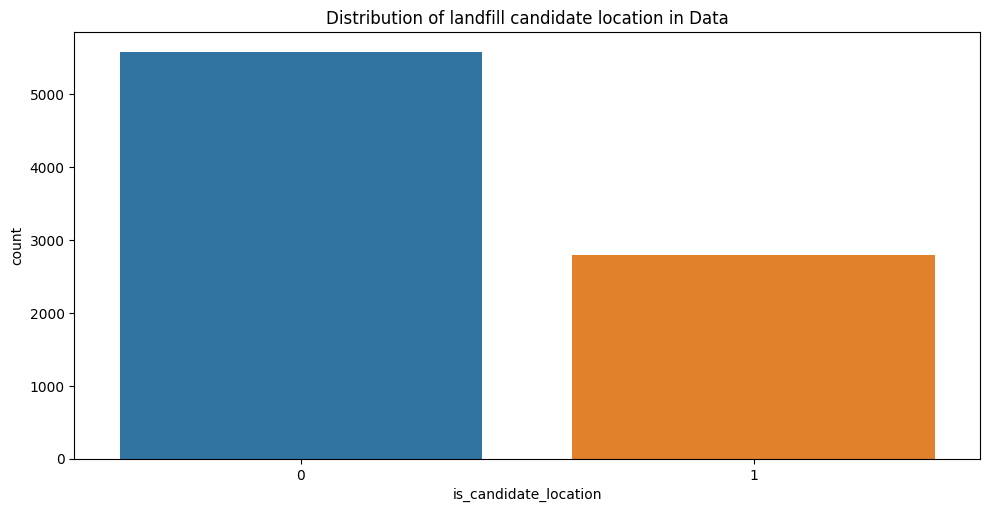

In [10]:
# train_filtered['site_type'].value_counts().plot(kind='bar', rot=45);
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='is_candidate_location', data=df)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
plt.tight_layout()
plt.title("Distribution of landfill candidate location in Data")
plt.savefig("landfill_distribution.png")
plt.show()

In [11]:
# # Assuming 'df' is your DataFrame and 'is_candidate_location' is the column of interest
# data = df['is_candidate_location'].value_counts()

# # Calculate percentages
# percentages = data / data.sum() * 100

# # Define the separation of sectors
# explode = [0.1] * len(data)  # This will separate all sectors slightly. Adjust as needed.

# # Create the pie chart
# plt.figure(figsize=(10, 5))
# plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, explode=explode)

# # Draw a circle at the center to turn the pie into a donut
# # centre_circle = plt.Circle((0,0),0.70,fc='white')
# # fig = plt.gcf()
# # fig.gca().add_artist(centre_circle)

# # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.axis('equal')  
# plt.title("Distribution of Landfill Candidate Location in Data")

# # Save the figure
# plt.savefig("landfill_distribution_pie.png")

# # Show the plot
# plt.show()

## Preview

**If landfill location is detected**

- **Check for severity perceived by the analyst at annotation (from 0 to 3)**
    
- **Check for evidence perceived by the analyst at annotation (from 0 to 3)**

- **Type of site (e.g production area)**

**If valid fine grain**

Image analyzed to observe Waste objects or storage modes present

- **Find the categories of waste objects or storage modes present on the images**

In [12]:
train_df = df[~df['evidence'].isin(['n/a', 'n/s']) & ~df['severity'].isin(['n/a', 'n/s'])].reset_index(drop=True)
test_df = df[df['evidence'].isin(['n/a', 'n/s']) & df['severity'].isin(['n/a', 'n/s'])].reset_index(drop=True)

In [13]:
# # Set the aesthetic style of the plots
# sns.set_style('whitegrid')

# # Plot the distribution of 'evidence' in the training data
# # plt.figure(figsize=(10, 6))
# # sns.countplot(x='evidence', data=train_df)
# # plt.title('Distribution of Evidence in Training Data')
# # plt.show()

# # Plot the distribution of 'severity' in the training data
# plt.figure(figsize=(10, 6))
# sns.countplot(x='severity', data=train_df)
# plt.title('Distribution of Severity in Data')
# plt.savefig('severity.png')
# plt.show()

# # # Plot the distribution of 'evidence' in the testing data
# # plt.figure(figsize=(10, 6))
# # sns.countplot(x='evidence', data=test_df)
# # plt.title('Distribution of Evidence in Testing Data')
# # plt.show()

# # # Plot the distribution of 'severity' in the testing data
# # plt.figure(figsize=(10, 6))
# # sns.countplot(x='severity', data=test_df)
# # plt.title('Distribution of Severity in Testing Data')
# # plt.show()

In [14]:
# # Bar plot for the 'severity' variable in the training data
# plt.figure(figsize=(15, 5))
# sns.barplot(x='site_type', y='severity', data=train_filtered, errorbar=None)
# plt.title('Severity by Site Type in Training Data Where is_candidate_location is True')
# plt.show()

# plt.figure(figsize=(15, 5))
# sns.barplot(x='site_type', y='evidence', data=train_filtered, errorbar=None)
# plt.title('Evidence by Site Type in Training Data Where is_candidate_location is True')
# plt.show()

In [15]:
# # Filter the dataframes where 'is_candidate_location' is True
# train_filtered = train_df[train_df['is_candidate_location']==1]
# test_filtered = test_df[test_df['is_candidate_location']==1]

# # Set the aesthetic style of the plots
# sns.set_style('whitegrid')

# # Visualize the distribution of 'site_type' with respect to 'severity' in the training data
# plt.figure(figsize=(15, 5))
# sns.countplot(x='site_type', hue='severity', data=train_filtered, palette='viridis')
# plt.title('Distribution of Site Type by Severity in Data')
# plt.legend(title='Severity')
# plt.savefig('site_severity.png')
# plt.show()

# # plt.figure(figsize=(15, 5))
# # sns.countplot(x='site_type', hue='evidence', data=train_filtered, palette='viridis')
# # plt.title('Distribution of Site Type by Severity in Data')
# # plt.legend(title='Evidence')
# # plt.show()

# # Visualize the distribution of 'site_type' with respect to 'evidence' in the training data
# # plt.figure(figsize=(10, 6))
# # # Rotate the x-labels to prevent overlap
# # g.set_xticklabels(rotation=45)
# # # Adjust the spacing between the facets
# # g.fig.subplots_adjust(wspace=0.2)
# # # Set the super title for the entire plot
# # g.fig.suptitle('Site Type by Evidence and Severity in Training Data', y=1.05)
# # plt.show()

In [16]:
# # train_filtered['site_type'].value_counts().plot(kind='bar', rot=45);
# plt.figure(figsize=(10, 5))
# ax = sns.countplot(x='site_type', data=train_filtered)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
# plt.tight_layout()
# plt.title("Distribution of site types in Data")
# plt.savefig("site_distribution.png")
# plt.show()

In [17]:
# # Create a catplot and set the size of each facet
# g = sns.catplot(x='site_type', 
#                 hue='evidence', 
#                 col='severity', 
#                 data=train_filtered, 
#                 kind='count', 
#                 palette='viridis', 
#                 height=6, 
#                 aspect=1)

# # Rotate the x-labels to prevent overlap
# g.set_xticklabels(rotation=45)

# # Adjust the spacing between the facets
# g.fig.subplots_adjust(wspace=0.2)

# # Set the super title for the entire plot
# g.fig.suptitle('Site Type by Evidence and Severity in Training Data', y=1.05)

# # Show the plot
# plt.show()

In [18]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming 'train_filtered' is your filtered training DataFrame
# # Create a contingency table
# contingency_table = pd.crosstab(train_filtered['severity'], train_filtered['evidence'])

# # Create a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(contingency_table, 
#             cmap='coolwarm', 
#             annot=True, 
#             fmt='d', 
#             linewidths=0.5, 
#             linecolor='grey', 
#             cbar=True, 
#             square=True,
#             vmin=0, 
#             vmax=100)
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.title('Customized Heatmap of Severity vs Evidence')
# plt.xlabel('Evidence')
# plt.ylabel('Severity')
# plt.show()

In [19]:
# test_df['is_candidate_location'].value_counts()

In [20]:
sites = train_df['site_type'].unique().tolist()
id2label = {k:v for k,v in enumerate(sites)}
label2id = {v:k for k,v in id2label.items()}

train_df['target_site'] = train_df['site_type'].map(label2id)
train_df['target_site'].value_counts()

target_site
1    836
2    478
0    395
5    165
4     94
3     88
Name: count, dtype: int64

In [21]:
class AerialMultiDataset(utils.data.Dataset):
    
    def __init__(self, data, transform, mode='train', label_name='severity'):
        super().__init__()
        self.data = data
        self.tsfm = transform
        self.mode = mode
        self.label = data.loc[:, label_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'image_path']
        severity = self.data.loc[idx, 'severity']
#         evidence = self.data.loc[idx, 'evidence']
        site = self.data.loc[idx, 'target_site']
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.tsfm(image=image)['image']
        
        return {"image": image, 
                "severity": torch.tensor(severity, dtype=torch.long), 
#                 "evidence": torch.tensor(evidence, dtype=torch.long),
                "site": torch.tensor(site, dtype=torch.long)
               }
    
    def get_labels(self):
        return self.label
    
class MultiLabelDataset(utils.data.Dataset):
    
    def __init__(self, data, transform, mode='train', label_name='severity'):
        super().__init__()
        self.data = data
        self.tsfm = transform
        self.mode = mode
        self.label = data.loc[:, label_name]
        self.num_site_classes = 6
        self.num_severe_classes = 4
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'image_path']
        severity = self.data.loc[idx, 'severity']
        site = self.data.loc[idx, 'target_site']
        
        severe_vector = torch.zeros(self.num_severe_classes)
        severe_vector[severity] = 1
        site_vector = torch.zeros(self.num_site_classes)
        site_vector[site] = 1
        
        
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.tsfm(image=image)['image']
        
        return {"image": image, 
                "severity": severe_vector, 
                "site": site_vector,
               }
    
    def get_labels(self):
        return self.label

In [22]:
# def get_transforms(height, width):
#     train_tsfm = A.Compose([
#         A.Resize(height=height, width=width),
#         A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        
#         A.OneOf([
#             A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1),
#             A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
#             A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1),
#         ], p=0.3),
        
#         A.OneOf([
#             A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1),
#             A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
#         ], p=0.2),
        
#         A.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225]),
#         ToTensorV2()
#     ])
    
#     valid_tsfm = A.Compose([
#         A.Resize(height=height, width=width),
#         A.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225]),
#         ToTensorV2()
#     ])
#     return {"train": train_tsfm, "eval": valid_tsfm}

def get_transforms(height, width):
    train_tsfm = A.Compose([
        # Geometric augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
        # Photometric augmentations
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#         A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#         A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        
        A.Resize(height=height, width=width),
        # Normalization and conversion to tensor
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    valid_tsfm = A.Compose([
        A.Resize(height=height, width=width),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    return {"train": train_tsfm, "eval": valid_tsfm}

def get_dataloaders(data, cfg, split="train", multi=False):
    img_size = cfg['img_size']
    height, width = img_size[0], img_size[1]
    tsfm = get_transforms(height=height, width=width)
    if split == 'train':
        tr_tsfm = tsfm['train']
        if multi:
            ds = MultiLabelDataset(data=data, transform=tr_tsfm)
        else:
            ds = AerialMultiDataset(data=data, transform=tr_tsfm)
            
        labels = ds.get_labels()
        class_weights = torch.tensor(compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels))
        samples_weights = class_weights[labels]

        sampler = utils.data.WeightedRandomSampler(weights=samples_weights, 
                                                   num_samples=len(samples_weights), 
                                                   replacement=True)

#         sampler=ImbalancedDatasetSampler(ds)
        dls = utils.data.DataLoader(ds, 
                                    batch_size=cfg['batch_size'], 
                                    sampler=sampler,
                                    num_workers=os.cpu_count(), 
                                    drop_last=True, 
                                    pin_memory=True)
        
    elif split == 'valid' or split == 'test':
        eval_tsfm = tsfm['eval']
        if multi:
            ds = MultiLabelDataset(data=data, transform=eval_tsfm)
        else:
            ds = AerialMultiDataset(data=data, transform=eval_tsfm)
        dls = utils.data.DataLoader(ds, 
                                    batch_size=2*cfg['batch_size'], 
                                    shuffle=False, 
                                    num_workers=os.cpu_count(), 
                                    drop_last=False, 
                                    pin_memory=True)
    else:
        raise Exception("Split should be 'train' or 'valid' or 'test'!!!")
    return dls

In [23]:
# # A.Normalize(mean=[0.485, 0.456, 0.406],
# #                         std=[0.229, 0.224, 0.225]),

# ts = A.Compose([
#     A.Resize(height=512, width=512),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2()
# ])

# ds = MultiLabelDataset(data=train_df, transform=ts)
# dls = utils.data.DataLoader(ds, batch_size=8, shuffle=True, num_workers=os.cpu_count())

In [24]:
# batch = next(iter(dls))
# torch.argmax(batch['site'], dim=1)

In [25]:
def check_class_distribution(data_loader):
    for i, batch in enumerate(data_loader):
        labels = batch['severity']
        class_distribution = Counter(labels.numpy())
        print(f"Batch {i+1}: Class Distribution: {class_distribution}")

# Assuming `train_loader` is your DataLoader
# check_class_distribution(dls)

In [26]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

# Feature Pyramid Network

In [27]:
def gap2d(x, keepdims=False):
    out = torch.mean(x.view(x.size(0), x.size(1), -1), -1)
    if keepdims:
        out = out.view(out.size(0), out.size(1), 1, 1)

    return out


class MultiResnetFPN(nn.Module):
    def __init__(self, name, site_classes, severe_classes, pretrained=False):
        super(MultiResnetFPN, self).__init__()
        self.site_classes = site_classes
        self.severe_classes = severe_classes
        self.encoder = timm.create_model(name, pretrained=pretrained, features_only=True)
        
        # first backbone layers
        self.stage0 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.act1,
                                   self.encoder.maxpool)
        
        # Backbone layers (bottom-up layer)
        self.stage1 = nn.Sequential(self.encoder.layer1)
        self.stage2 = nn.Sequential(self.encoder.layer2)
        self.stage3 = nn.Sequential(self.encoder.layer3)
        self.stage4 = nn.Sequential(self.encoder.layer4)
        
        if 'resnet18' in name.lower() or 'resnet34' in name.lower():
            in_chans = self.encoder.layer4[-1].conv2.out_channels
        if 'resnet50' in name.lower():
            in_chans = self.encoder.layer4[-1].conv3.out_channels
        
        out_chans = in_chans // 8
        # Top Layer
        self.toplayer = nn.Conv2d(
            in_chans, out_chans, kernel_size=1, stride=1, padding=0)

        # Lateral Layers
        self.latlayer1 = nn.Conv2d(
            in_chans // 2, out_chans, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(
            in_chans // 4, out_chans, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(
            out_chans, out_chans, kernel_size=1, stride=1, padding=0)
        
        # smooth layers
        mid_chans = in_chans // 2 - out_chans
        self.smooth1 = nn.Conv2d(in_chans // 4, out_chans, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(mid_chans, out_chans, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(in_chans // 2, out_chans, kernel_size=3, stride=1, padding=1)
        
        # fully connected layer
        self.site_fc = nn.Linear(out_chans, site_classes)
        self.site_classifier = nn.Linear(4*site_classes, site_classes)
        
        self.severe_fc = nn.Linear(out_chans, severe_classes)
        self.severe_classifier = nn.Linear(4*severe_classes, severe_classes)
        
    def forward(self, x):
        # bottom-up pathway 
        c1 = self.stage0(x)
        c2 = self.stage1(c1)
        c3 = self.stage2(c2).detach()
        c4 = self.stage3(c3)
        c5 = self.stage4(c4)
        
        # top-down pathway
        p5 = self.toplayer(c5)
        p4 = self._upsample_cat(p5, self.latlayer1(c4))
        p3 = self._upsample_cat(p4, self.latlayer2(c3))
        p2 = self._upsample_cat(p3, self.latlayer3(c2))
        
        # smoothing (de-aliasing effect)
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        # Global Average Pooling
        p5 = gap2d(p5, keepdims=True)
        p4 = gap2d(p4, keepdims=True)
        p3 = gap2d(p3, keepdims=True)
        p2 = gap2d(p2, keepdims=True)
        
        # Flattening
        p5 = p5.view(p5.size(0), -1)
        p4 = p4.view(p4.size(0), -1)
        p3 = p3.view(p3.size(0), -1)
        p2 = p2.view(p2.size(0), -1)
        
        # Fully connected layers
        site_out5 = F.relu(self.site_fc(p5))
        site_out4 = F.relu(self.site_fc(p4))
        site_out3 = F.relu(self.site_fc(p3))
        site_out2 = F.relu(self.site_fc(p2))
        
        severe_out5 = F.relu(self.severe_fc(p5))
        severe_out4 = F.relu(self.severe_fc(p4))
        severe_out3 = F.relu(self.severe_fc(p3))
        severe_out2 = F.relu(self.severe_fc(p2))
        
        # concatenate the predictions (classification results) of each of the pyramid features
        site_out = torch.cat([site_out5, site_out4, site_out3, site_out2], dim=1)
        site_out = self.site_classifier(site_out)
        
        severe_out = torch.cat([severe_out5, severe_out4, severe_out3, severe_out2], dim=1)
        severe_out = self.severe_classifier(severe_out)
        return site_out, severe_out
    
    def _upsample_cat(self, x, y):
        _, _, H, W = y.size()
        upsampled_x = F.interpolate(
            x, size=(H,W), mode="nearest"
        )
        return torch.cat([upsampled_x, y], dim=1)

In [28]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [29]:
def shared_step(batch, criterion, params):
    image, severe, site = batch["image"], batch["severity"], batch["site"]
    image = image.to(params["device"], non_blocking=True)
    severe = severe.to(params["device"], non_blocking=True)
    site = site.to(params["device"], non_blocking=True)
    site_logits, severe_logits = model.forward(image.to(torch.float32))
    site_loss = criterion(site_logits, site.to(torch.int64))
    prob_site = F.softmax(site_logits, dim=-1)
    pred_site = torch.argmax(prob_site, dim=-1)

    severe_loss = criterion(severe_logits, severe.to(torch.int64))
    prob_severe = F.softmax(severe_logits, dim=-1)
    pred_severe = torch.argmax(prob_severe, dim=-1)
    return {
        "site_loss": site_loss,
        "severe_loss": severe_loss,
        "site_preds": pred_site,
        "severe_preds": pred_severe
    }
    
    
def train(train_loader, model, criterion, optimizer, epoch, scaler, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    for i, batch in enumerate(stream, start=1):
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = shared_step(batch, criterion, params)
            loss =  outputs['site_loss'] + outputs['severe_loss']
        
#         accuracy = METRICS['accuracy'](predictions, target)
#         jaccard = METRICS['jaccard_index'](predictions, target)
#         fbeta = METRICS['fbeta_score'](predictions, target)
        
        metric_monitor.update("Loss", loss.item())
#         metric_monitor.update("Accuracy", accuracy)
#         metric_monitor.update("Jaccard", jaccard)
#         metric_monitor.update("FBeta", fbeta)
        
        train_loss += loss.detach().float()
        lr = optimizer.param_groups[0]['lr']
        _train_metrics = {
            "train/step_loss": loss.item(),
            "learning_rate": lr,
#             "train/accuracy": accuracy,
#             "train/jaccard_index": jaccard,
#             "train/fbeta_score": fbeta
        }
        
        if (i+1) % 50 == 0:
            wandb.log(_train_metrics)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
        
    total_train_loss = train_loss / len(train_loader)
    
    gc.collect()
    flush()
    return _train_metrics, total_train_loss
        
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    valid_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(stream, start=1):
            outputs = shared_step(batch, criterion, params)
            loss =  outputs['site_loss'] + outputs['severe_loss']
            
#             accuracy = METRICS['accuracy'](predictions, target)
#             jaccard = METRICS['jaccard_index'](predictions, target)
#             fbeta = METRICS['fbeta_score'](predictions, target)

            metric_monitor.update("Loss", loss.item())
#             metric_monitor.update("Accuracy", accuracy)
#             metric_monitor.update("Jaccard", jaccard)
#             metric_monitor.update("FBeta", fbeta)
            
            valid_loss += loss.detach().float()
            _valid_metrics = {
                "valid/step_loss": loss.item(),
#                 "valid/loss": valid_loss,
#                 "valid/accuracy": accuracy,
#                 "valid/jaccard_index": jaccard,
#                 "valid/fbeta_score": fbeta
            }

            if (i+1) % 10 == 0:
                wandb.log(_valid_metrics)
            
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
#         if epoch%9 == 0:
#             print(f"##### Visualizing mini batches at epoch {epoch} ####")
#             visualize_mini_batches(batch, predictions)
    gc.collect()
    flush()
    total_valid_loss = valid_loss / len(val_loader)
    return _valid_metrics, total_valid_loss

In [30]:
def train_and_validate(model, train_dataset, val_dataset, params, fold=0):
    model = model.to(params['device'])
    run = wandb.init(
        project="PlasticOpticsMultiClassification", 
        resume="allow"
    )
    
    artifact = wandb.Artifact(f"aerialMultiFPNModel_fold_{fold}", type="model")
    
    train_loader = get_dataloaders(train_data, cfg=CONFIG, split='train', multi=False)
    val_loader = get_dataloaders(valid_data, cfg=CONFIG, split="valid", multi=False)
    
    criterion = nn.CrossEntropyLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    scaler = torch.cuda.amp.GradScaler()
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
#                                                                      params['epochs'], 
#                                                                      eta_min=0)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['epochs'], eta_min=0)
    lr_reduce = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)
    best_metric = np.inf
    loss_min = np.inf
    es = 0
    ES_RATIO = 0.25 if params['epochs'] < 10 else 0.20
#     seg_weights_file = "aerialwaste_fpn_weights.pth"
    weights_file = "aerialwaste_multi_task_fold_{fold}_epoch_{epoch}.pth"
    for epoch in range(1, params["epochs"] + 1):
        scheduler.step()
        _train_metrics, train_loss = train(train_loader, model, criterion, optimizer, epoch, scaler, params)
        _valid_metrics, val_loss = validate(val_loader, model, criterion, epoch, params)
        
        _train_metrics["train/loss"] = train_loss
        _valid_metrics["valid/loss"] = val_loss
        lr_reduce.step(val_loss)
        wandb.log({**_train_metrics, **_valid_metrics})
        if val_loss < best_metric:
            print(f"Best metric: ({best_metric:.6f} --> {val_loss:.6f}). Saving model ...")
#             torch.save(model.module.state_dict(), f"{name}_fold_{fold}.pth")
            weights_file.format(fold=fold, epoch=epoch)
            torch.save(model.state_dict(), weights_file)
            best_metric = val_loss
            es = 0
            if epoch == 1:
                artifact.add_file(weights_file)
                run.log_artifact(artifact)
            else:
                draft_artifact = wandb.Artifact(f"aerialMultiFPNModel_fold_{fold}", type="model")
                draft_artifact.add_file(weights_file)
                run.log_artifact(draft_artifact)
            
        else:
            es += 1
            
        if es > math.ceil(ES_RATIO*params['epochs']):
            print(f"Early stopping on epoch {epoch} ...")
            break
            
    wandb.config = params
    wandb.finish()
    flush()

In [31]:
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
train_df = train_df.sample(frac=1.0, random_state=2024)
x = train_df.index.values
# y = train_df['severity'].astype(int).values
y = train_df['severity'].astype(int).values
g = train_df['target_site'].astype(int).values

train_df['fold'] = -1
for fold, (tr_idx, val_idx) in enumerate(kfold.split(x,y)):
    train_df.loc[val_idx, 'fold'] = fold

In [32]:
CONFIG['lr'] = 3e-4
for fold in range(5):
    model = MultiResnetFPN(name='resnet34', site_classes=6, severe_classes=4, pretrained=True)
    train_data = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_data = train_df[train_df['fold'] == fold].reset_index(drop=True)
    train_and_validate(model, train_data, valid_data, params=CONFIG, fold=fold)
    
gc.collect()
flush()

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

wandb: Currently logged in as: samu2505. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (inf --> 2.942984). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.942984 --> 2.656048). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.656048 --> 2.464422). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.464422 --> 2.425446). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.425446 --> 2.378098). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.378098 --> 2.375860). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.375860 --> 2.343814). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 2.3817e-05.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.343814 --> 2.270952). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.8730e-06.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 1.4058e-07.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Early stopping on epoch 27 ...


learning_rate,████████████▇▇▇▇▇▇▇▇▇▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/step_loss,█▇▆▅▅▅▅▅▄▄▃▃▆▅▅▄▄▂▃▃▄▃▃▁▂▁▃▂▃▃▄▃▃▂▃▅▃▂▃▂
valid/loss,█▅▃▃▂▂▂▃▃▂▂▃▃▂▂▁▂▁▁▁▁▂▂▂▂▁▁
valid/step_loss,▆█▅▄▄▃▃▄▃▃▄▃▃▅▄▂▄▅▃▄▄▃▂▂▁▃▂▂▁▃▁▁▃▂▁▃▂▂▂▃
learning_rate,0.0
train/loss,1.01014
train/step_loss,0.88342
valid/loss,2.31165
valid/step_loss,2.36457


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (inf --> 2.892582). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.892582 --> 2.777687). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.777687 --> 2.609022). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.609022 --> 2.584892). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.584892 --> 2.498288). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.498288 --> 2.457701). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 2.5268e-05.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 2.1387e-06.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Early stopping on epoch 19 ...


learning_rate,█████████████████▇▇▇▇▇▇▇▇▇▇▇▂▂▂▂▁▁▁▁▁▁▁▁
train/loss,█▇▆▅▄▃▄▃▃▂▂▂▂▁▁▁▁▁▁
train/step_loss,▇▆█▇▅▅▅▇▇▄▃▄▃▄▃▃▃▂▄▄▅▄▄▃▂▃▂▂▃▃▃▂▁▃▃▃▁▁▃▂
valid/loss,▇█▆▃▃▂▂▁▂▄▂▂▁▂▁▂▁▁▁
valid/step_loss,▇█▇█▆▇▅▅▆▆▂▃▄▅▃▄▄▅▄▆▃▇▂▅▁▆▂▅▁▆▂▆▁▆▁▆▁▇
learning_rate,0.0
train/loss,1.22566
train/step_loss,0.99326
valid/loss,2.47053
valid/step_loss,2.67839


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (inf --> 2.795638). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.795638 --> 2.690984). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.690984 --> 2.604726). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.604726 --> 2.486273). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 2.7135e-05.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.486273 --> 2.480856). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.480856 --> 2.463279). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.463279 --> 2.442024). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.0522e-06.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 1.5942e-07.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Early stopping on epoch 25 ...


learning_rate,█████████████▇▇▇▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/step_loss,█▇▅▇▅▄▂▄▅▄▅▄▃▃▄▃▃▂▂▂▂▄▂▄▂▃▂▂▂▂▃▂▂▂▂▂▄▂▁▂
valid/loss,█▆▄▆▂▅▃▆▄▂▂▁▂▁▂▂▁▂▂▁▁▁▂▂▁
valid/step_loss,█▄▆▂▂▄▂▃▆▂▄▄▃▄▁▄▅▁▄▁▂▄▂▄▅▂▄▂▃▄▂▄▄▃▄▂▃▄▃▂
learning_rate,0.0
train/loss,1.17186
train/step_loss,1.27458
valid/loss,2.46436
valid/step_loss,2.63649


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (inf --> 2.933050). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.933050 --> 2.683589). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.683589 --> 2.605495). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.605495 --> 2.508903). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.508903 --> 2.373917). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 2.3817e-05.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.373917 --> 2.367036). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.367036 --> 2.355025). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.355025 --> 2.336689). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.336689 --> 2.334118). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Best metric: (2.334118 --> 2.326448). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 1.5000e-06.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.0365e-07.


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Early stopping on epoch 31 ...


learning_rate,███████████▇▇▇▇▇▇▇▇▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/step_loss,█▇▆▄▄▄▅▅▃▅▃▃▃▅▃▃▅▄▃▃▁▂▂▃▃▃▃▂▃▄▄▂▄▂▂▃▃▃▂▂
valid/loss,█▅▄▄▃▃▅▄▄▂▂▂▂▂▃▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
valid/step_loss,██▆▆▇▄▃▆▇▇▅▃▇▆▃▄▃▇▆▃▂▆▅▁▁▁▆▆▁▁▆▆▆▁▁▆▆▁▁▁
learning_rate,0.0
train/loss,1.25293
train/step_loss,1.06588
valid/loss,2.34845
valid/step_loss,1.84714


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af669310940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


Best metric: (inf --> 2.959573). Saving model ...


  0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# batch = next(iter(dls))
# model = MultiResnetFPN(name='resnet18', site_classes=6, severe_classes=4)
# model.eval()
# site, severe = model(batch['image'])

In [ ]:
# criterion = AsymmetricLossOptimized()
# criterion(batch['site'], site), criterion(batch['severity'], severe)

In [ ]:
# class MultiFPNModel(pl.LightningModule):
#     def __init__(self, name, site_classes, severe_classes, pretrained=False, lr=1e-3):
#         super().__init__()
#         self.save_hyperparameters()
#         self.model = MultiResnetFPN(name=name, 
#                                     site_classes=site_classes, 
#                                     severe_classes=severe_classes, 
#                                     pretrained=pretrained)
#         self.loss_fn = nn.CrossEntropyLoss()
# #         self.loss_fn = AsymmetricLossOptimized()
#         self.step_outputs = []
#         self.site_acc = torchmetrics.Accuracy(num_classes=site_classes, task="multiclass", average="micro")
#         self.severe_acc = torchmetrics.Accuracy(num_classes=severe_classes, task="multiclass", average="micro")
        
#     def forward(self, x):
#         return self.model(x)
    
#     def shared_step(self, batch, stage):
#         image, severe, site = batch["image"], batch["severity"], batch["site"]
#         site_logits, severe_logits = self.forward(image.to(torch.float32))
# #         loss_site = self.loss_fn(site, site_logits)
#         loss_site = self.loss_fn(site_logits, site.to(torch.int64))
#         prob_site = F.softmax(site_logits, dim=-1)
#         pred_site = torch.argmax(prob_site, dim=-1)
        
# #         loss_severe = self.loss_fn(severe, severe_logits)
#         loss_severe = self.loss_fn(severe_logits, severe.to(torch.int64))
#         prob_severe = F.softmax(severe_logits, dim=-1)
#         pred_severe = torch.argmax(prob_severe, dim=-1)
        
#         total_loss = loss_site + loss_severe
        
#         site_acc = self.site_acc(pred_site, site)
#         severe_acc = self.severe_acc(pred_severe, severe)
#         self.log(f"{stage}_site_loss", loss_site, on_step=False, on_epoch=True, prog_bar=True)
#         self.log(f"{stage}_severe_loss", loss_severe, on_step=False, on_epoch=True, prog_bar=True)
#         self.log(f"{stage}_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
#         self.log(f"{stage}_site_acc", site_acc, on_step=False, on_epoch=True, prog_bar=False)
#         self.log(f"{stage}_severe_acc", severe_acc, on_step=False, on_epoch=True, prog_bar=False)
        
#         output = {
#             f"{stage}_loss": total_loss,
#             f"{stage}_site_acc": site_acc,
#             f"{stage}_severe_acc": severe_acc,
#         }
# #         self.step_outputs.append(output)
#         return output
    
#     def training_step(self, batch, batch_idx):
#         outputs = self.shared_step(batch, "train")
#         return outputs['train_loss']
    
#     def validation_step(self, batch, batch_idx):
#         self.eval()
#         return self.shared_step(batch, "valid")
        
#     def test_step(self, batch, batch_idx):
#         return self.shared_step(batch, "test")  
    
#     def configure_optimizers(self):
#         max_epochs = self.trainer.max_epochs
#         optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
# #         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#         cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=0.0)
#         plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
#                                                                        factor=0.1, patience=10, 
#                                                                        threshold=0.0001, cooldown=0, 
#                                                                        min_lr=0, eps=1e-08, verbose=True)
# #         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
# #             optimizer, T_0=10, T_mult=2)
#         scheduler = {
#             'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=0),
#             'interval': 'epoch',
#             'frequency': 1,
#             'monitor': 'val_loss',  # Make sure to replace 'val_loss' with your actual validation metric
#         }
#         scheduler_plateau = {
#             'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
#             'interval': 'epoch',
#             'frequency': 1,
#             'monitor': 'valid_loss',  # Make sure to replace 'val_loss' with your actual validation metric
#             'strict': True,
#         }
#         return [optimizer], [scheduler, scheduler_plateau]

In [ ]:
# kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
# train_df = train_df.sample(frac=1.0, random_state=2024)
# x = train_df.index.values
# # y = train_df['severity'].astype(int).values
# y = train_df['severity'].astype(int).values
# g = train_df['target_site'].astype(int).values

# train_df['fold'] = -1
# for fold, (tr_idx, val_idx) in enumerate(kfold.split(x,y)):
#     train_df.loc[val_idx, 'fold'] = fold

In [ ]:
# CONFIG['patience'] = 8 if CONFIG['epochs'] < 50 else 12
# for fold in range(5):
#     train_data = train_df[train_df['fold'] != fold].reset_index(drop=True)
#     valid_data = train_df[train_df['fold'] == fold].reset_index(drop=True)
#     train_dls = get_dataloaders(train_data, cfg=CONFIG, split='train', multi=False)
#     valid_dls = get_dataloaders(valid_data, cfg=CONFIG, split="valid", multi=False)

#     net = MultiFPNModel(name='resnet50', 
#                         site_classes=6, 
#                         severe_classes=4, 
#                         pretrained=True, lr=1e-4)

#     wandb_logger = WandbLogger(project="Plastic-Optics-multi-classification-FPN",
#                                checkpoint_name=f"aerialMultiFPNModel_fold_{fold}", 
#                                log_model="all")

#     callbacks = [
#         ModelCheckpoint(save_weights_only=True, 
#                         mode="min", 
#                         monitor="valid_loss"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
#         LearningRateMonitor("epoch"),
#         EarlyStopping(monitor="valid_loss", min_delta=0.0, patience=CONFIG['patience'], verbose=False, mode="min"),
#     ]
#     # trainer = pl.Trainer(fast_dev_run=100)
#     trainer = pl.Trainer(max_epochs=CONFIG['epochs'], logger=wandb_logger, callbacks=callbacks)
#     trainer.fit(net, train_dataloaders=train_dls, val_dataloaders=valid_dls)
    
#     break
# wandb.finish()

In [ ]:
# model = MultiFPNModel(name='resnet18', site_classes=6, severe_classes=4)
# trainer = pl.Trainer(max_epochs=10)
# trainer.fit(model, train_dataloaders=dls)

In [ ]:
# torch.save(model.state_dict(), 'aerial_multi.pth')

# Efficient Net Model

In [ ]:
# class AerialLightningModel(pl.LightningModule):
#     def __init__(self, 
#                  name: str, 
#                  site_classes: int = 0, 
#                  severity_classes: int = 0, 
# #                  evidence_classes: int = 0, 
#                  pretrained: bool = False, 
#                  kernel_size: int = 3, 
#                  stride: int = 2, 
#                  lr: float = 3e-4):
        
#         super().__init__()
#         self.save_hyperparameters()
#         self.encoder = timm.create_model(name, pretrained=pretrained, num_classes=0)
#         nb_fts = self.encoder.num_features
#         nb_fts = nb_fts // stride
#         self.nb_fts = nb_fts if kernel_size < 3 else nb_fts - 1
#         self.avg_pool = nn.AvgPool1d(kernel_size, stride=stride)
        
#         self.flatten = nn.Flatten()
#         self.site_head = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(self.nb_fts, 384),
#             nn.ReLU(),
# #             nn.BatchNorm1d(768),
#             nn.Dropout(0.2),
#             nn.Linear(384, 4*site_classes),
#             nn.ReLU(),
# #             nn.BatchNorm1d(256),
#             nn.Dropout(0.2),
#             nn.Linear(4*site_classes, site_classes)
#         )
        
#         self.severe_head = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(self.nb_fts, 384),
#             nn.ReLU(),
# #             nn.BatchNorm1d(768),
#             nn.Dropout(0.2),
#             nn.Linear(384, 4*severity_classes),
#             nn.ReLU(),
# #             nn.BatchNorm1d(256),
#             nn.Dropout(0.2),
#             nn.Linear(4*severity_classes, severity_classes)
#         )

        
#         self.loss_function = nn.CrossEntropyLoss()
#         self.step_outputs = []
#         self.site_acc = torchmetrics.Accuracy(num_classes=site_classes, task="multiclass", average="micro")
#         self.severe_acc = torchmetrics.Accuracy(num_classes=severity_classes, task="multiclass", average="micro")
        
        
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.flatten(x)
#         x = self.avg_pool(x)
        
#         site_outputs = self.site_head(x)
#         severe_outputs = self.severe_head(x)
#         return site_outputs, severe_outputs
    
#     def shared_step(self, batch, stage):
#         image, severe, site = batch["image"], batch["severity"], batch["site"]
#         site_logits, severe_logits = self.forward(image.to(torch.float32))
        
#         loss_site = self.loss_function(site_logits, site.to(torch.int64))
#         prob_site = F.softmax(site_logits, dim=-1)
#         pred_site = torch.argmax(prob_site, dim=-1)
        
#         loss_severe = self.loss_function(severe_logits, severe.to(torch.int64))
#         prob_severe = F.softmax(severe_logits, dim=-1)
#         pred_severe = torch.argmax(prob_severe, dim=-1)
        
#         total_loss = loss_site + loss_severe
#         site_acc = self.site_acc(pred_site, site)
#         severe_acc = self.severe_acc(pred_severe, severe)
#         self.log(f"{stage}_site_loss", loss_site, on_step=False, on_epoch=True, prog_bar=True)
#         self.log(f"{stage}_severe_loss", loss_severe, on_step=False, on_epoch=True, prog_bar=True)
#         self.log(f"{stage}_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
#         self.log(f"{stage}_site_acc", site_acc, on_step=False, on_epoch=True, prog_bar=False)
#         self.log(f"{stage}_severe_acc", severe_acc, on_step=False, on_epoch=True, prog_bar=False)
        
#         output = {
#             f"{stage}_loss": total_loss,
#             f"{stage}_site_acc": site_acc,
#             f"{stage}_severe_acc": severe_acc,
#         }
#         self.step_outputs.append(output)
#         return output
    
#     def training_step(self, batch, batch_idx):
#         outputs = self.shared_step(batch, "train")
#         return outputs['train_loss']
    
#     def validation_step(self, batch, batch_idx):
#         self.eval()
#         return self.shared_step(batch, "valid")
        
#     def test_step(self, batch, batch_idx):
#         return self.shared_step(batch, "test")  
    
#     def configure_optimizers(self):
#         max_epochs = self.trainer.max_epochs
#         optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
# #         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#         cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=0.0)
#         plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
#                                                                        factor=0.1, patience=10, 
#                                                                        threshold=0.0001, cooldown=0, 
#                                                                        min_lr=0, eps=1e-08, verbose=True)
# #         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
# #             optimizer, T_0=10, T_mult=2)
#         scheduler = {
#             'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=0),
#             'interval': 'epoch',
#             'frequency': 1,
#             'monitor': 'val_loss',  # Make sure to replace 'val_loss' with your actual validation metric
#         }
#         scheduler_plateau = {
#             'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
#             'interval': 'epoch',
#             'frequency': 1,
#             'monitor': 'valid_loss',  # Make sure to replace 'val_loss' with your actual validation metric
#             'strict': True,
#         }
#         return [optimizer], [scheduler, scheduler_plateau]

In [ ]:
# kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
# train_df = train_df.sample(frac=1.0, random_state=2024)
# x = train_df.index.values
# # y = train_df['severity'].astype(int).values
# y = train_df['severity'].astype(int).values
# g = train_df['target_site'].astype(int).values

# train_df['fold'] = -1
# for fold, (tr_idx, val_idx) in enumerate(kfold.split(x,y)):
#     train_df.loc[val_idx, 'fold'] = fold
    
# # train_df['fold'].value_counts()
# # train_df.groupby(['fold'])[['site_type', 'evidence', 'severity']].value_counts().reset_index()

# # train_data = train_df[train_df['fold'].isin([0,1,3,4])].reset_index(drop=True)
# # valid_data = train_df[~train_df['fold'].isin([0,1,3,4])].reset_index(drop=True)
# # train_data.shape, valid_data.shape

In [ ]:
# CONFIG['patience'] = 8 if CONFIG['epochs'] < 50 else 12
# for fold in range(5):
#     train_data = train_df[train_df['fold'] != fold].reset_index(drop=True)
#     valid_data = train_df[train_df['fold'] == fold].reset_index(drop=True)
#     train_dls = get_dataloaders(train_data, cfg=CONFIG, split='train')
#     valid_dls = get_dataloaders(valid_data, cfg=CONFIG, split="valid")

#     net = AerialLightningModel(name='efficientnet_b3.ra2_in1k', 
#                                site_classes=6, 
#                                severity_classes=4, 
#     #                            evidence_classes=4, 
#                                pretrained=True, lr=2e-5)

#     wandb_logger = WandbLogger(project="Plastic-Optics-multi-classification",
#                                checkpoint_name=f"aerialMultiModel_fold_{fold}", 
#                                log_model="all")

#     callbacks = [
#         ModelCheckpoint(save_weights_only=True, 
#                         mode="min", 
#                         monitor="valid_loss"),
#         LearningRateMonitor("epoch"),
#         EarlyStopping(monitor="valid_loss", 
#                       min_delta=0.0, patience=CONFIG['patience'], 
#                       verbose=False, mode="min"),
#     ]
#     # trainer = pl.Trainer(fast_dev_run=100)
#     trainer = pl.Trainer(max_epochs=CONFIG['epochs'], 
#                          logger=wandb_logger, callbacks=callbacks)
#     trainer.fit(net, train_dataloaders=train_dls, val_dataloaders=valid_dls)
    
#     break
# wandb.finish()

In [ ]:
# timm.list_pretrained("efficientnet*")

```python
The class distribution across the batches you've provided shows variability, which is expected in real-world datasets. However, if your goal is to achieve more balanced batches, especially for training a model where class imbalance could be an issue, you might consider the following steps:

1. **Review Sampler**: Ensure you're using a sampler that promotes class balance, such as `WeightedRandomSampler` or `ImbalancedDatasetSampler`. These samplers can help in creating batches with a more even class distribution.

2. **Adjust Batch Size**: If feasible, adjust the batch size. A smaller batch size might help in getting a more uniform distribution of classes, although it could also increase training time.

3. **Custom Batch Creation**: Create a custom batch creation loop that manually ensures each batch has a balanced class distribution. This might involve more complex data handling but can provide you with the exact distribution you need.

4. **Post-Processing**: After each batch is created, you could potentially swap out samples from over-represented classes with those from under-represented classes to balance the batch. This would require additional logic in your data loading process.

5. **Data Augmentation**: For under-represented classes, consider using data augmentation techniques to increase the number of samples, which can then be used to create more balanced batches.

6. **Analysis and Reporting**: If the class distribution is critical for your analysis, consider reporting the distribution as part of your model's performance metrics. This can provide insight into how well the model might perform on an imbalanced dataset.

If you're satisfied with the current distribution and it's not causing issues with model training, you may not need to take any action. However, if you're observing that the model's performance is being negatively impacted by the imbalance, then implementing one or more of the above strategies could be beneficial.

Would you like to explore any of these options in more detail or need assistance with another aspect of your project? 😊
```

```python
For validation purposes, it's not strictly necessary for the batches to be balanced. The primary goal of validation is to assess the model's performance on a dataset that represents the real-world distribution of classes. Therefore, the validation set should ideally reflect the true class distribution you expect the model to encounter in practice.

Balancing the validation batches could potentially skew the performance metrics and give an unrealistic picture of how the model would perform on naturally imbalanced data. It's important for the validation process to provide a clear indication of the model's ability to generalize to new, unseen data.

However, if your validation set is extremely imbalanced, it might be difficult for the model to adequately learn the characteristics of the minority class. In such cases, you might consider using techniques like stratified sampling to ensure that all classes are represented in the validation set.

In summary, while training batches benefit from being balanced to prevent the model from being biased towards the majority class, validation batches should maintain the original data distribution to accurately evaluate the model's performance.

If you have any more questions or need further assistance, feel free to ask! 😊
```

In [ ]:
# import pandas as pd
# from collections import Counter

# def check_class_distribution(data_loader):
#     batch_distributions = []
#     for i, batch in enumerate(tqdm(data_loader)):
#         labels = batch['severity']
#         class_distribution = Counter(labels.numpy())
#         batch_distributions.append({'Batch': i+1, 'Class Distribution': class_distribution})
    
#     # Convert to DataFrame
#     df = pd.DataFrame(batch_distributions)
    
#     # Expand the 'Class Distribution' column into separate columns
#     class_distributions = df['Class Distribution'].apply(pd.Series)
#     df = pd.concat([df.drop(['Class Distribution'], axis=1), class_distributions], axis=1).fillna(0).astype(int)
    
#     return df

# # Assuming `train_loader` is your DataLoader
# df = check_class_distribution(train_dls)

In [ ]:
# df